### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from numpy.linalg import LinAlgError
import scipy
from plot_inlier_matches import plot_inlier_matches
import skimage

### Step 1: Preprocessing

In [2]:
## load and convert both images to grayscale
img1_bgr = cv2.imread('images/parliament-left.jpg')
img2_bgr = cv2.imread('images/parliament-right.jpg')

img1_rgb = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)

img1_gray = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2GRAY)

### Step 2: Detect keypoints and extract descriptors

In [3]:
kp1, des1 = cv2.SIFT_create().detectAndCompute(img1_gray, None)
kp2, des2 = cv2.SIFT_create().detectAndCompute(img2_gray, None)

### Step 3: Match features

In [4]:
dm = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')

### Step 4: Prune features

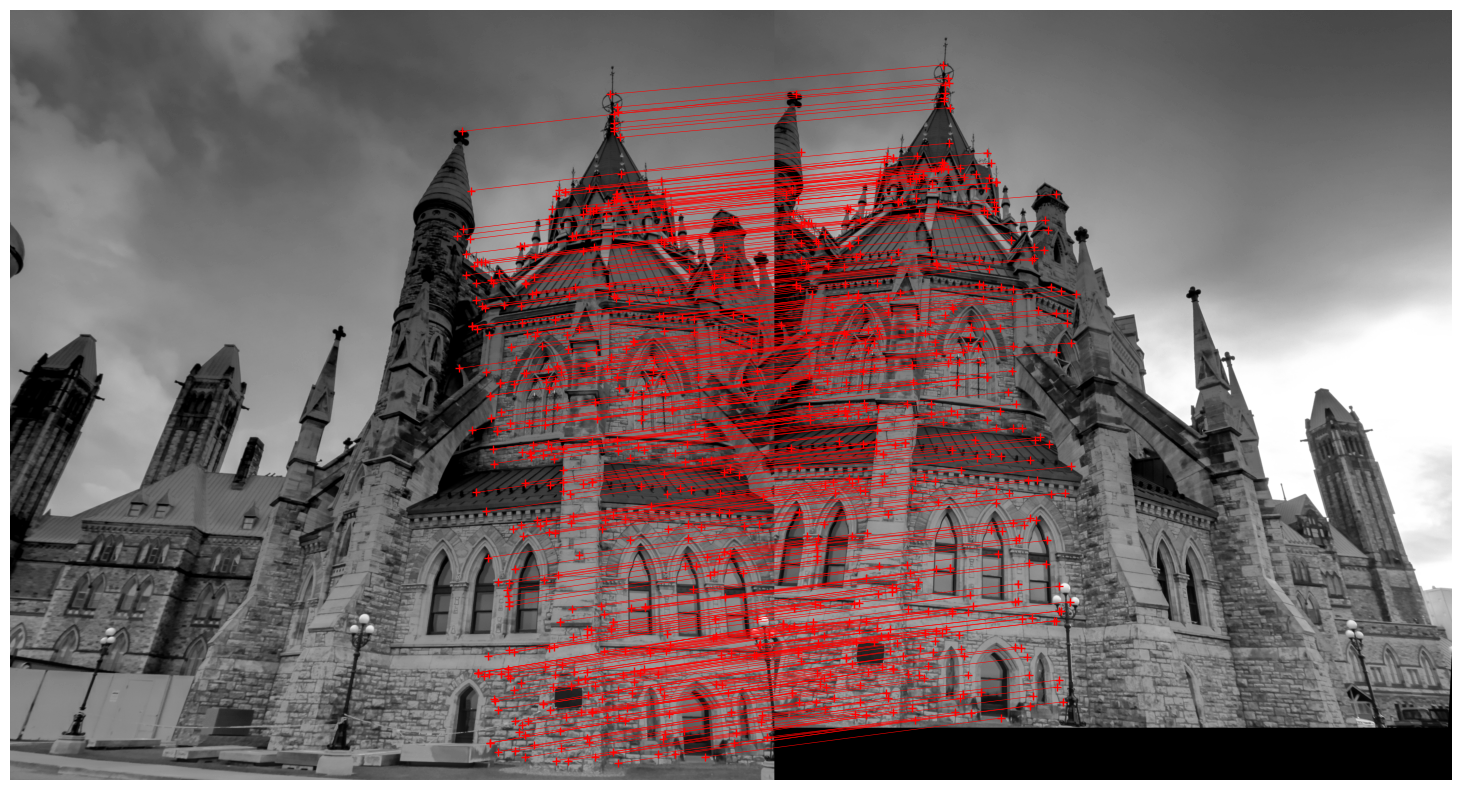

In [5]:
## n = number of best matches
n = 400

## sort and get best n matches
dm_sorted = np.argsort(dm.flatten())[:n]
row, col = np.unravel_index(dm_sorted, dm.shape)

## convert keypoints from cv2.KeyPoint tuples to np.float64 array, only keep top n matches
kp1_closest = np.array([kp.pt for kp in kp1])[row]
kp2_closest = np.array([kp.pt for kp in kp2])[col]

## visualize keypoints
inlier_matrix = np.hstack((kp1_closest, kp2_closest))
fig, ax = plt.subplots(figsize=(20, 10))
plot_inlier_matches(ax, img1_gray, np.pad(img2_gray, ((0, img1_gray.shape[0] - img2_gray.shape[0]), (0, 0)), mode='constant', constant_values=0.0), inlier_matrix)

### Step 5: Robust transformation estimation

To estimate an affine transformation, a minimum of 3 random sets of points are required.

In [6]:
## define number of iterations and threshold
num_iter = 2000
threshold = 0.08

## variables to hold best inliers and count
inlier_count = 0
best_inliers_idx = None

## RANSAC
for i in range(num_iter):
    retry_iteration = True

    while retry_iteration:
        try:
            ## select 3 random indices
            random_idx = np.random.choice(kp1_closest.shape[0], size=3, replace=False)

            img1_pts = kp1_closest[random_idx]
            img2_pts = kp2_closest[random_idx]

            ## estimate affine transformation with inverse transformation
            A = np.hstack((img1_pts, np.ones((img1_pts.shape[0], 1))))
            x = np.transpose(np.linalg.inv(A) @ img2_pts)
            T = x[:, :2]
            c = x[:, 2]

            ## calculate the n img2 points with the estimated T and c
            img2_new = kp1_closest @ np.transpose(T) + c

            ## compute the euclidean distance and count entries that are within the radius threshold
            distance = np.linalg.norm(img2_new - kp2_closest, axis=1)
            inliers = np.where(distance < threshold)[0]
            count = len(inliers)

            ## save the best affine matrix and inlier counts
            if count > inlier_count:
                inlier_count = count
                best_inliers_idx = inliers

            print(f"Iteration {i} - count (current): {count} - count (best): {inlier_count}")
            retry_iteration = False

        ## sometimes A does not have an inverse, in that case, choose 3 sets of points randomly again
        except LinAlgError:
            continue

Iteration 0 - count (current): 12 - count (best): 12
Iteration 1 - count (current): 11 - count (best): 12
Iteration 2 - count (current): 20 - count (best): 20
Iteration 3 - count (current): 12 - count (best): 20
Iteration 4 - count (current): 126 - count (best): 126
Iteration 5 - count (current): 22 - count (best): 126
Iteration 6 - count (current): 11 - count (best): 126
Iteration 7 - count (current): 80 - count (best): 126
Iteration 8 - count (current): 68 - count (best): 126
Iteration 9 - count (current): 77 - count (best): 126
Iteration 10 - count (current): 49 - count (best): 126
Iteration 11 - count (current): 12 - count (best): 126
Iteration 12 - count (current): 49 - count (best): 126
Iteration 13 - count (current): 45 - count (best): 126
Iteration 14 - count (current): 116 - count (best): 126
Iteration 15 - count (current): 22 - count (best): 126
Iteration 16 - count (current): 179 - count (best): 179
Iteration 17 - count (current): 66 - count (best): 179
Iteration 18 - count 

### Step 6: Compute optimal transformation

In [7]:
## get all the inliers of the best transformation found using RANSAC
img1_pts_final = kp1_closest[best_inliers_idx]
img2_pts_final = kp2_closest[best_inliers_idx]

A_final = np.hstack((img1_pts_final, np.ones((img1_pts_final.shape[0], 1))))

## compute the final T and c with least-squares (pseudo-inverse)
x_final = np.transpose(np.linalg.inv(np.transpose(A_final) @ A_final) @ np.transpose(A_final) @ img2_pts_final)

### Step 7: Create panorama

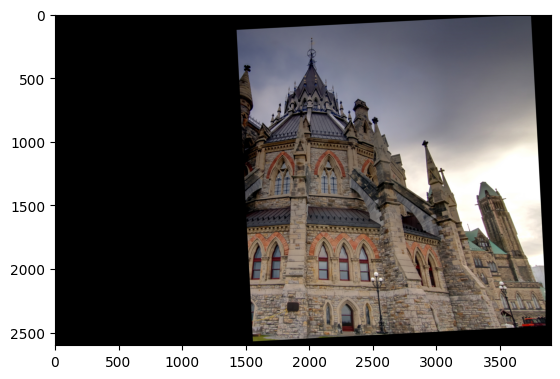

In [8]:
## perform image warping
## turn x_final into a 3x3 matrix by adding row [0, 0, 1] at the bottom
transform = skimage.transform.ProjectiveTransform(np.vstack((x_final, [0, 0, 1])))
warped_img2 = skimage.transform.warp(img2_rgb, transform, output_shape=(2600, 3900))

plt.imshow(warped_img2)

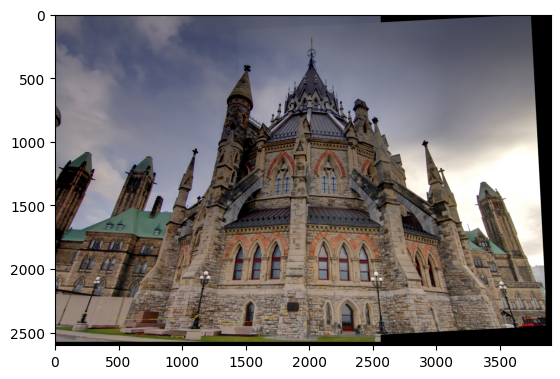

In [9]:
## add more pixels on the right of img1 to create the panorama
padded_img1 = np.pad(img1_rgb, ((0, warped_img2.shape[0] - img1_rgb.shape[0]), (0, warped_img2.shape[1] - img1_rgb.shape[1]), (0, 0)), mode='constant', constant_values=0.0).astype(np.float32) / 255.

## take the maximum of both images
plt.imshow(np.maximum(padded_img1, warped_img2))